# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 3, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.5,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_56_drop0.25e500b512_custom/lnets_10000_280-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_3_d_5_sparsity_56_amin_-1_amax_1_xdist_uniform_noise_normal_0.5
lnets_10000_280-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_3_d_5_sparsity_56_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.5


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/216 [00:00<?, ?it/s]

List length: 216
Number of monomials in a polynomial with 3 variables and degree 5: 56
Sparsity: 56
['000', '001', '002', '003', '004', '005', '010', '011', '012', '013', '014', '015', '020', '021', '022', '023', '024', '025', '030', '031', '032', '033', '034', '035', '040', '041', '042', '043', '044', '045', '050', '051', '052', '053', '054', '055', '100', '101', '102', '103', '104', '105', '110', '111', '112', '113', '114', '115', '120', '121', '122', '123', '124', '125', '130', '131', '132', '133', '134', '135', '140', '141', '142', '143', '144', '145', '150', '151', '152', '153', '154', '155', '200', '201', '202', '203', '204', '205', '210', '211', '212', '213', '214', '215', '220', '221', '222', '223', '224', '225', '230', '231', '232', '233', '234', '235', '240', '241', '242', '243', '244', '245', '250', '251', '252', '253', '254', '255', '300', '301', '302', '303', '304', '305', '310', '311', '312', '313', '314', '315', '320', '321', '322', '323', '324', '325', '330', '331', '33

  0%|          | 0/216 [00:00<?, ?it/s]

List length: 56
Number of monomials in a polynomial with 3 variables and degree 5: 56
Sparsity: 56
['000', '001', '002', '003', '004', '005', '010', '011', '012', '013', '014', '020', '021', '022', '023', '030', '031', '032', '040', '041', '050', '100', '101', '102', '103', '104', '110', '111', '112', '113', '120', '121', '122', '130', '131', '140', '200', '201', '202', '203', '210', '211', '212', '220', '221', '230', '300', '301', '302', '310', '311', '320', '400', '401', '410', '500']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:  5.6min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 1570)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 1570)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 1570)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,000-target,001-target,002-target,003-target,004-target,005-target,010-target,011-target,012-target,013-target,014-target,020-target,021-target,022-target,023-target,030-target,031-target,032-target,040-target,041-target,050-target,100-target,101-target,102-target,103-target,104-target,110-target,111-target,112-target,113-target,120-target,121-target,122-target,130-target,131-target,140-target,200-target,201-target,202-target,203-target,210-target,211-target,212-target,220-target,221-target,230-target,300-target,301-target,302-target,310-target,311-target,320-target,400-target,401-target,410-target,500-target,000-lstsq_lambda,001-lstsq_lambda,002-lstsq_lambda,003-lstsq_lambda,004-lstsq_lambda,005-lstsq_lambda,010-lstsq_lambda,011-lstsq_lambda,012-lstsq_lambda,013-lstsq_lambda,014-lstsq_lambda,020-lstsq_lambda,021-lstsq_lambda,022-lstsq_lambda,023-lstsq_lambda,030-lstsq_lambda,031-lstsq_lambda,032-lstsq_lambda,040-lstsq_lambda,041-lstsq_lambda,050-lstsq_lambda,100-lstsq_lambda,101-lstsq_lambda,102-lstsq_lambda,103-lstsq_lambda,104-lstsq_lambda,110-lstsq_lambda,111-lstsq_lambda,112-lstsq_lambda,113-lstsq_lambda,120-lstsq_lambda,121-lstsq_lambda,122-lstsq_lambda,130-lstsq_lambda,131-lstsq_lambda,140-lstsq_lambda,200-lstsq_lambda,201-lstsq_lambda,202-lstsq_lambda,203-lstsq_lambda,210-lstsq_lambda,211-lstsq_lambda,212-lstsq_lambda,220-lstsq_lambda,221-lstsq_lambda,230-lstsq_lambda,300-lstsq_lambda,301-lstsq_lambda,302-lstsq_lambda,310-lstsq_lambda,311-lstsq_lambda,320-lstsq_lambda,400-lstsq_lambda,401-lstsq_lambda,410-lstsq_lambda,500-lstsq_lambda,000-lstsq_target,001-lstsq_target,002-lstsq_target,003-lstsq_target,004-lstsq_target,005-lstsq_target,010-lstsq_target,011-lstsq_target,012-lstsq_target,013-lstsq_target,014-lstsq_target,020-lstsq_target,021-lstsq_target,022-lstsq_target,023-lstsq_target,030-lstsq_target,031-lstsq_target,032-lstsq_target,040-lstsq_target,041-lstsq_target,050-lstsq_target,100-lstsq_target,101-lstsq_target,102-lstsq_target,103-lstsq_target,104-lstsq_target,110-lstsq_target,111-lstsq_target,112-lstsq_target,113-lstsq_target,120-lstsq_target,121-lstsq_target,122-lstsq_target,130-lstsq_target,131-lstsq_target,140-lstsq_target,200-lstsq_target,201-lstsq_target,202-lstsq_target,203-lstsq_target,210-lstsq_target,211-lstsq_target,212-lstsq_target,220-lstsq_target,221-lstsq_target,230-lstsq_target,300-lstsq_target,301-lstsq_target,302-lstsq_target,310-lstsq_target,311-lstsq_target,320-lstsq_target,400-lstsq_target,401-lstsq_target,410-lstsq_target,500-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,...,wb_1151,wb_1152,wb_1153,wb_1154,wb_1155,wb_1156,wb_1157,wb_1158,wb_1159,wb_1160,wb_1161,wb_1162,wb_1163,wb_1164,wb_1165,wb_1166,wb_1167,wb_1168,wb_1169,wb_1170,wb_1171,wb_1172,wb_1173,wb_1174,wb_1175,wb_1176,wb_1177,wb_1178,wb_1179,wb_1180,wb_1181,wb_1182,wb_1183,wb_1184,wb_1185,wb_1186,wb_1187,wb_1188,wb_1189,wb_1190,wb_1191,wb_1192,wb_1193,wb_1194,wb_1195,wb_1196,wb_1197,wb_1198,wb_1199,wb_1200,wb_1201,wb_1202,wb_1203,wb_1204,wb_1205,wb_1206,wb_1207,wb_1208,wb_1209,wb_1210,wb_1211,wb_1212,wb_1213,wb_1214,wb_1215,wb_1216,wb_1217,wb_1218,wb_1219,wb_1220,wb_1221,wb_1222,wb_1223,wb_1224,wb_1225,wb_1226,wb_1227,wb_1228,wb_1229,wb_1230,wb_1231,wb_1232,wb_1233,wb_1234,wb_1235,wb_1236,wb_1237,wb_1238,wb_1239,wb_1240,wb_1241,wb_1242,wb_1243,wb_1244,wb_1245,wb_1246,wb_1247,wb_1248,wb_1249,wb_1250,wb_1251,wb_1252,wb_1253,wb_1254,wb_1255,wb_1256,wb_1257,wb_1258,wb_1259,wb_1260,wb_1261,wb_1262,wb_1263,wb_1264,wb_1265,wb_1266,wb_1267,wb_1268,wb_1269,wb_1270,wb_1271,wb_1272,wb_1273,wb_1274,wb

## Interpretation Network Training

In [21]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 49 Complete [00h 07m 30s]
val_loss: 0.10890238732099533

Best val_loss So Far: 0.10344936698675156
Total elapsed time: 09h 20m 10s

Search: Running Trial #50

Hyperparameter    |Value             |Best Value So Far 
dense_block_1/u...|False             |False             
dense_block_1/n...|1                 |1                 
dense_block_1/u...|1024              |1024              
dense_block_1/d...|0.5               |0.5               
dense_block_1/u...|32                |32                
regression_head...|0                 |0                 
optimizer         |adam_weight_decay |adam              
learning_rate     |2e-05             |2e-05             
dense_block_1/u...|256               |256               

Epoch 1/500
254/254 [==============================] - 8s 30ms/step - loss: 1.0525 - val_loss: 1.0359
Epoch 2/500
254/254 [==============================] - 7s 26ms/step - loss: 1.0137 - val_loss: 0.9751
Epoch 3/500
254/254 [==============================] - 8s 31

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 7s 28ms/step - loss: 0.2739 - val_loss: 0.2300
Epoch 19/500
254/254 [==============================] - 7s 28ms/step - loss: 0.2676 - val_loss: 0.2242
Epoch 20/500
254/254 [==============================] - 8s 30ms/step - loss: 0.2627 - val_loss: 0.2211
Epoch 21/500
254/254 [==============================] - 7s 29ms/step - loss: 0.2551 - val_loss: 0.2151
Epoch 22/500
254/254 [==============================] - 7s 28ms/step - loss: 0.2510 - val_loss: 0.2099
Epoch 23/500
254/254 [==============================] - 7s 28ms/step - loss: 0.2443 - val_loss: 0.2051
Epoch 24/500
254/254 [==============================] - 7s 28ms/step - loss: 0.2402 - val_loss: 0.2009
Epoch 25/500
254/254 [==============================] - 7s 29ms/step - loss: 0.2356 - val_loss: 0.1962
Epoch 26/500
254/254 [==============================] - 8s 30ms/step - loss: 0.2313 - val_loss: 0.1928
Epoch 27/500
254/254 [==============================] - 7s 29ms/step - loss: 0.2275 - 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 7s 29ms/step - loss: 0.1632 - val_loss: 0.1293
Epoch 69/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1627 - val_loss: 0.1294
Epoch 70/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1629 - val_loss: 0.1287
Epoch 71/500
254/254 [==============================] - 8s 32ms/step - loss: 0.1620 - val_loss: 0.1300
Epoch 72/500
254/254 [==============================] - 8s 30ms/step - loss: 0.1624 - val_loss: 0.1276
Epoch 73/500
254/254 [==============================] - 8s 30ms/step - loss: 0.1607 - val_loss: 0.1287
Epoch 74/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1610 - val_loss: 0.1274
Epoch 75/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1602 - val_loss: 0.1276
Epoch 76/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1605 - val_loss: 0.1265
Epoch 77/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1596 - 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 8s 31ms/step - loss: 0.1495 - val_loss: 0.1165
Epoch 115/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1498 - val_loss: 0.1167
Epoch 116/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1499 - val_loss: 0.1175
Epoch 117/500
254/254 [==============================] - 8s 30ms/step - loss: 0.1497 - val_loss: 0.1166
Epoch 118/500
254/254 [==============================] - 7s 30ms/step - loss: 0.1499 - val_loss: 0.1158
Epoch 119/500
254/254 [==============================] - 8s 30ms/step - loss: 0.1493 - val_loss: 0.1158
Epoch 120/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1492 - val_loss: 0.1162
Epoch 121/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1496 - val_loss: 0.1155
Epoch 122/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1486 - val_loss: 0.1158
Epoch 123/500
254/254 [==============================] - 7s 28ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 8s 33ms/step - loss: 0.1433 - val_loss: 0.1114
Epoch 163/500
254/254 [==============================] - 8s 32ms/step - loss: 0.1437 - val_loss: 0.1110
Epoch 164/500
254/254 [==============================] - 8s 33ms/step - loss: 0.1437 - val_loss: 0.1109
Epoch 165/500
254/254 [==============================] - 8s 33ms/step - loss: 0.1434 - val_loss: 0.1123
Epoch 166/500
254/254 [==============================] - 8s 31ms/step - loss: 0.1427 - val_loss: 0.1116
Epoch 167/500
254/254 [==============================] - 8s 31ms/step - loss: 0.1436 - val_loss: 0.1114
Epoch 168/500
254/254 [==============================] - 8s 31ms/step - loss: 0.1437 - val_loss: 0.1119
Epoch 169/500
254/254 [==============================] - 8s 31ms/step - loss: 0.1433 - val_loss: 0.1119
Epoch 170/500
254/254 [==============================] - 8s 32ms/step - loss: 0.1431 - val_loss: 0.1110
Epoch 171/500
254/254 [==============================] - 8s 31ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 7s 28ms/step - loss: 0.2245 - val_loss: 0.1835
Epoch 9/500
254/254 [==============================] - 7s 29ms/step - loss: 0.2183 - val_loss: 0.1785
Epoch 10/500
254/254 [==============================] - 7s 28ms/step - loss: 0.2120 - val_loss: 0.1746
Epoch 11/500
254/254 [==============================] - 7s 29ms/step - loss: 0.2085 - val_loss: 0.1703
Epoch 12/500
254/254 [==============================] - 7s 28ms/step - loss: 0.2037 - val_loss: 0.1671
Epoch 13/500
254/254 [==============================] - 7s 27ms/step - loss: 0.2020 - val_loss: 0.1649
Epoch 14/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1976 - val_loss: 0.1620
Epoch 15/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1953 - val_loss: 0.1594
Epoch 16/500
254/254 [==============================] - 6s 24ms/step - loss: 0.1934 - val_loss: 0.1575
Epoch 17/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1911 - v

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 7s 28ms/step - loss: 0.1591 - val_loss: 0.1262
Epoch 52/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1593 - val_loss: 0.1251
Epoch 53/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1584 - val_loss: 0.1245
Epoch 54/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1579 - val_loss: 0.1247
Epoch 55/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1583 - val_loss: 0.1245
Epoch 56/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1567 - val_loss: 0.1236
Epoch 57/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1568 - val_loss: 0.1232
Epoch 58/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1567 - val_loss: 0.1241
Epoch 59/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1555 - val_loss: 0.1224
Epoch 60/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1555 - 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 7s 29ms/step - loss: 0.1464 - val_loss: 0.1147
Epoch 99/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1476 - val_loss: 0.1135
Epoch 100/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1465 - val_loss: 0.1135
Epoch 101/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1470 - val_loss: 0.1146
Epoch 102/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1469 - val_loss: 0.1150
Epoch 103/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1471 - val_loss: 0.1139
Epoch 104/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1466 - val_loss: 0.1139
Epoch 105/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1462 - val_loss: 0.1145
Epoch 106/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1456 - val_loss: 0.1126
Epoch 107/500
254/254 [==============================] - 7s 29ms/step - loss: 0

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 7s 29ms/step - loss: 0.1415 - val_loss: 0.1085
Epoch 146/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1413 - val_loss: 0.1090
Epoch 147/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1418 - val_loss: 0.1085
Epoch 148/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1410 - val_loss: 0.1093
Epoch 149/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1406 - val_loss: 0.1089
Epoch 150/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1412 - val_loss: 0.1086
Epoch 151/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1405 - val_loss: 0.1092
Epoch 152/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1409 - val_loss: 0.1092
Epoch 153/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1410 - val_loss: 0.1097
Epoch 154/500
254/254 [==============================] - 7s 28ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 7s 29ms/step - loss: 0.1380 - val_loss: 0.1056
Epoch 195/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1381 - val_loss: 0.1059
Epoch 196/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1369 - val_loss: 0.1064
Epoch 197/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1367 - val_loss: 0.1068
Epoch 198/500
254/254 [==============================] - 7s 29ms/step - loss: 0.1375 - val_loss: 0.1053
Epoch 199/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1375 - val_loss: 0.1053
Epoch 200/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1365 - val_loss: 0.1055
Epoch 201/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1373 - val_loss: 0.1063
Epoch 202/500
254/254 [==============================] - 7s 28ms/step - loss: 0.1372 - val_loss: 0.1052
Epoch 203/500
254/254 [==============================] - 7s 28ms/step - loss: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



254/254 [==============================] - 7s 26ms/step - loss: 0.1353 - val_loss: 0.1026
Epoch 245/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1345 - val_loss: 0.1054
Epoch 246/500
254/254 [==============================] - 7s 26ms/step - loss: 0.1347 - val_loss: 0.1040
Epoch 247/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1349 - val_loss: 0.1035
Epoch 248/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1353 - val_loss: 0.1031
Epoch 249/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1342 - val_loss: 0.1042
Epoch 250/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1347 - val_loss: 0.1028
Epoch 251/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1344 - val_loss: 0.1048
Epoch 252/500
254/254 [==============================] - 7s 27ms/step - loss: 0.1338 - val_loss: 0.1038
Epoch 253/500
254/254 [==============================] - 7s 27ms/step - loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 660.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 660.9min finished


## Evaluate Interpretation Net

In [22]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 2e-05
dense_block_1/units_2: 256
Score: 0.10344936698675156
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 128
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 2e-05
dense_block_1/units_2: 256
Score: 0.10510291904211044
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 2e-05
dense_block_1/units_2: 64
Score: 0.10705532133579254
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1


In [23]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1401)]            0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 1401)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1435648   
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 1457)              1493425   
Total params: 2,929,073
Trainable params: 2,929,073
Non-trainable params: 0
____________________________________________

In [24]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.493,0.595,13.426,0.058,0.000,0.142,0.196,1.563,0.855,0.231,1.082,0.186,0.021,0.019,1.302,1.351
inetPoly_VS_targetPoly_test,0.494,0.598,41.053,0.060,0.000,0.144,0.198,1.886,0.886,0.220,1.038,0.189,0.022,0.015,1.300,1.349
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.097,0.120,1.448,0.961,0.145,0.430,0.108,0.021,0.019,1.302,1.328
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.097,0.121,0.939,0.966,0.139,0.417,0.109,0.022,0.016,1.300,1.324
inetPoly_VS_lstsqTarget_valid,3.858,6.651,98.894,0.019,0.000,0.095,0.119,1.302,0.962,0.142,0.469,0.106,0.021,0.019,1.302,1.327
inetPoly_VS_lstsqTarget_test,3.926,6.866,173.888,0.019,0.000,0.095,0.119,0.872,0.967,0.136,0.447,0.107,0.022,0.016,1.300,1.324
inetPoly_VS_lstsqLambda_valid,3.858,6.651,98.894,0.019,0.000,0.095,0.119,1.302,0.962,0.142,0.469,0.106,0.021,0.019,1.302,1.327
inetPoly_VS_lstsqLambda_test,3.926,6.866,173.888,0.019,0.000,0.095,0.119,0.872,0.967,0.136,0.447,0.107,0.022,0.016,1.300,1.324
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.020,0.027,0.148,0.998,0.029,0.142,0.027,0.019,0.019,1.327,1.328
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.020,0.027,0.175,0.998,0.028,0.144,0.027,0.016,0.016,1.324,1.324


In [25]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.123,0.122,0.164,0.099,0.138,0.146,0.172,0.091,0.107,0.156,0.165,0.170,0.129,0.227,0.146,0.148,0.113,0.172,0.129,0.107,0.188,0.116,0.134,0.151,0.111,0.160,0.140,0.186,0.160,0.140,0.132,0.138,0.140,0.131,0.099,0.100,0.105,0.127,0.095,0.145,0.173,0.167,0.119,0.137,0.174,0.148,0.159,0.171,0.148,0.237,0.196,0.128,0.081,0.133,0.107,0.146,0.136,0.192,0.170,0.118,0.165,0.105,0.131,0.143,0.156,0.088,0.104,0.142,0.116,0.100,0.103,0.195,0.199,0.156,0.179,0.108,0.122,0.214,0.157,0.132,0.113,0.162,0.116,0.151,0.144,0.117,0.117,0.122,0.145,0.121,0.143,0.125,0.184,0.145,0.147,0.176,0.160,0.133,0.137,0.125,0.095,0.133,0.143,0.191,0.114,0.173,0.158,0.156,0.176,0.110,0.146,0.184,0.168,0.128,0.131,0.146,0.119,0.113,0.158,0.134,0.132,0.186,0.113,0.162,0.181,0.156,0.106,0.153,0.176,0.173,0.106,0.151,0.158,0.155,0.186,0.090,0.122,0.159,0.162,0.142,0.128,0.106,0.150,0.217,0.146,0.107,0.195,0.131,0.121,0.103,0.118,0.166,0.190,0.101,0.182,0.155,0.094,0.166,0.139,0.115,0.146,0.125,0.141,0.157,0.232,0.127,0.091,0.154,0.136,0.092,0.154,0.102,0.153,0.130,0.115,0.124,0.159,0.191,0.145,0.

In [26]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.963,0.961,0.957,0.737,0.200,0.815,0.984,0.973,0.976,0.970,0.908,0.734,0.937,0.568,0.961,0.895,0.884,0.915,0.325,0.957,0.710,0.869,0.931,0.958,0.963,0.957,0.796,0.958,0.926,0.944,0.942,0.974,0.958,0.905,0.949,0.889,0.983,0.956,0.988,0.949,0.928,0.933,0.977,0.937,0.701,-1.749,0.917,-0.678,0.946,-0.347,0.741,0.943,0.954,0.869,0.883,0.933,0.782,0.920,0.939,0.867,0.870,0.973,0.948,0.980,0.949,0.991,0.934,0.943,0.863,0.523,0.953,0.940,0.950,0.804,0.934,0.875,0.757,0.953,0.935,0.923,0.830,0.972,0.646,0.976,0.952,0.981,0.935,0.726,0.738,0.948,0.762,0.961,0.891,0.893,0.802,0.756,0.953,0.977,0.879,0.941,0.948,0.882,0.347,0.964,0.939,0.967,0.960,0.825,0.934,0.943,0.849,0.866,0.797,0.939,0.690,0.576,0.887,0.973,0.433,0.806,0.954,0.947,0.916,0.969,0.708,0.955,0.979,0.711,0.881,0.922,0.945,0.769,0.838,0.882,0.896,0.936,0.937,0.608,0.823,0.942,0.976,0.982,0.855,0.929,0.613,0.862,0.558,0.970,0.916,0.974,0.956,0.966,0.375,0.956,0.956,0.942,0.958,0.890,0.933,0.812,0.972,0.959,0.965,0.931,0.954,0.961,0.954,0.971,0.959,0.951,0.914,0.935,0.894,0.951,0.914,0.879,0.467,0.957,0.924

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.632510307576414


0.159807711839676*a**1.0*b**1.0*c**1.0 + 0.088524341583252*a**1.0*b**1.0*c**2.0 + 0.149210587143898*a**1.0*b**1.0*c**3.0 - 0.276062160730362*a**1.0*b**1.0 - 0.185800299048424*a**1.0*b**2.0*c**1.0 - 0.125869870185852*a**1.0*b**2.0*c**2.0 - 0.158552408218384*a**1.0*b**2.0 - 0.0684216320514679*a**1.0*b**3.0*c**1.0 + 0.0366186052560806*a**1.0*b**3.0 + 0.0877168998122215*a**1.0*b**4.0 + 1.20840132236481*a**1.0*c**1.0 + 0.727439165115356*a**1.0*c**2.0 + 0.0716183260083199*a**1.0*c**3.0 - 0.228834584355354*a**1.0*c**4.0 + 0.00474197836592793*a**1.0 + 0.12016611546278*a**2.0*b**1.0*c**1.0 + 0.2001071870327*a**2.0*b**1.0*c**2.0 - 0.409163385629654*a**2.0*b**1.0 - 0.172351405024529*a**2.0*b**2.0*c**1.0 - 0.0304770171642303*a**2.0*b**2.0 + 0.0598364882171154*a**2.0*b**3.0 + 0.756086111068726*a**2.0*c**1.0 + 0.41754350066185*a**2.0*c**2.0 - 0.309539526700974*a**2.0*c**3.0 - 0.412036716938019*a**2.0 + 0.107422113418579*a**3.0*b**1.0*c**1.0 - 0.148209899663925*a**3.0*b**1.0 + 0.204012975096703*a**3.

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.679339927315185


2.07124870373325*a**1.0*b**1.0*c**1.0 - 8.43322392083354*a**1.0*b**1.0*c**2.0 + 4.48331784320166*a**1.0*b**1.0*c**3.0 - 0.6104921975274*a**1.0*b**1.0 + 1.66158503186655*a**1.0*b**2.0*c**1.0 + 0.804444427671442*a**1.0*b**2.0*c**2.0 + 1.35575740115746*a**1.0*b**2.0 - 3.70462368270468*a**1.0*b**3.0*c**1.0 + 0.525466729396134*a**1.0*b**3.0 + 0.611806364420855*a**1.0*b**4.0 + 4.26588180259386*a**1.0*c**1.0 - 0.21858052317448*a**1.0*c**2.0 - 3.45279570386684*a**1.0*c**3.0 + 1.73178369006056*a**1.0*c**4.0 - 0.433525064374648*a**1.0 - 0.863811927587379*a**2.0*b**1.0*c**1.0 + 0.0422834906670672*a**2.0*b**1.0*c**2.0 + 0.449144122463199*a**2.0*b**1.0 + 0.165366340106509*a**2.0*b**2.0*c**1.0 - 4.25454523454857*a**2.0*b**2.0 + 0.541248604304166*a**2.0*b**3.0 - 0.307899856111256*a**2.0*c**1.0 + 9.85898820550985*a**2.0*c**2.0 - 7.8970312122123*a**2.0*c**3.0 - 3.12962689300433*a**2.0 + 4.01332166446255*a**3.0*b**1.0*c**1.0 + 1.34068836574696*a**3.0*b**1.0 + 1.57400933319622*a**3.0*b**2.0 - 4.142947727

In [29]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.712428418506505*a**1.0*b**1.0*c**1.0 - 0.664008890199161*a**1.0*b**1.0*c**2.0 - 0.454128241575745*a**1.0*b**1.0*c**3.0 + 0.0792744198373534*a**1.0*b**1.0 + 0.30684356747568*a**1.0*b**2.0*c**1.0 - 0.718477194908199*a**1.0*b**2.0*c**2.0 - 0.611657940845175*a**1.0*b**2.0 - 0.499127417671602*a**1.0*b**3.0*c**1.0 + 0.585045102786506*a**1.0*b**3.0 - 0.489049076041007*a**1.0*b**4.0 + 0.305311676924316*a**1.0*c**1.0 + 0.869467547403708*a**1.0*c**2.0 - 0.635564409461994*a**1.0*c**3.0 + 0.873787514395358*a**1.0*c**4.0 + 0.0439085508916701*a**1.0 - 0.475126193382644*a**2.0*b**1.0*c**1.0 + 0.344363931846557*a**2.0*b**1.0*c**2.0 - 0.79749155797855*a**2.0*b**1.0 - 0.299941870188867*a**2.0*b**2.0*c**1.0 + 0.237101281515566*a**2.0*b**2.0 + 0.725686646829304*a**2.0*b**3.0 + 0.49277619090003*a**2.0*c**1.0 + 0.848431903219338*a**2.0*c**2.0 + 0.815020028320954*a**2.0*c**3.0 - 0.437757407218056*a**2.0 - 0.225026859101631*a**3.0*b**1.0*c**1.0 + 0.0543492441034623*a**3.0*b**1.0 + 0.959470198855252*a**3.0*b

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.88629231681733


-0.0204725880175829*a**1.0*b**1.0*c**1.0 + 0.0425382032990456*a**1.0*b**1.0*c**2.0 + 0.278175175189972*a**1.0*b**1.0*c**3.0 - 0.474032163619995*a**1.0*b**1.0 + 0.111072406172752*a**1.0*b**2.0*c**1.0 - 0.265257626771927*a**1.0*b**2.0*c**2.0 - 0.356533348560333*a**1.0*b**2.0 + 0.0244182888418436*a**1.0*b**3.0*c**1.0 - 0.0694650039076805*a**1.0*b**3.0 + 0.175123527646065*a**1.0*b**4.0 - 0.350374281406403*a**1.0*c**1.0 + 0.167562499642372*a**1.0*c**2.0 - 0.0544642582535744*a**1.0*c**3.0 - 0.00174066051840782*a**1.0*c**4.0 - 0.887940287590027*a**1.0 - 0.111061945557594*a**2.0*b**1.0*c**1.0 - 0.058141753077507*a**2.0*b**1.0*c**2.0 - 0.244963511824608*a**2.0*b**1.0 + 0.15570142865181*a**2.0*b**2.0*c**1.0 - 0.0304589401930571*a**2.0*b**2.0 + 0.160718142986298*a**2.0*b**3.0 + 0.140157833695412*a**2.0*c**1.0 - 0.282037764787674*a**2.0*c**2.0 + 0.0869811326265335*a**2.0*c**3.0 - 0.475965976715088*a**2.0 - 0.0535562187433243*a**3.0*b**1.0*c**1.0 + 0.102377265691757*a**3.0*b**1.0 + 0.14782400429248

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.8642082549632379


-0.721303393233737*a**1.0*b**1.0*c**1.0 + 0.161401734679864*a**1.0*b**1.0*c**2.0 + 0.0816641882051707*a**1.0*b**1.0*c**3.0 - 0.690922350680017*a**1.0*b**1.0 + 0.118928789471609*a**1.0*b**2.0*c**1.0 - 0.290052480850185*a**1.0*b**2.0*c**2.0 + 0.811782939245383*a**1.0*b**2.0 + 0.199545287588868*a**1.0*b**3.0*c**1.0 - 0.0083106482205417*a**1.0*b**3.0 - 0.202490933473762*a**1.0*b**4.0 + 0.172714800412879*a**1.0*c**1.0 - 0.0331740470006421*a**1.0*c**2.0 + 0.417998757585722*a**1.0*c**3.0 - 0.0377840291763046*a**1.0*c**4.0 - 1.6172374512539*a**1.0 + 0.444029801036781*a**2.0*b**1.0*c**1.0 + 0.0002117183448465*a**2.0*b**1.0*c**2.0 + 0.678525300472766*a**2.0*b**1.0 - 0.0062139113141504*a**2.0*b**2.0*c**1.0 - 0.920149497345794*a**2.0*b**2.0 + 0.370317664112945*a**2.0*b**3.0 - 0.253808238883367*a**2.0*c**1.0 - 0.574962168601542*a**2.0*c**2.0 - 0.295786987172567*a**2.0*c**3.0 - 0.404792648772384*a**2.0 - 0.186684805613525*a**3.0*b**1.0*c**1.0 - 0.11872298454505*a**3.0*b**1.0 - 0.0149097289907215*a**

In [32]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.902340606066858*a**1.0*b**1.0*c**1.0 - 0.0537173646957229*a**1.0*b**1.0*c**2.0 + 0.325036416376148*a**1.0*b**1.0*c**3.0 - 0.698211088549933*a**1.0*b**1.0 + 0.0105352062285022*a**1.0*b**2.0*c**1.0 - 0.835235059599265*a**1.0*b**2.0*c**2.0 - 0.0594222256125003*a**1.0*b**2.0 + 0.282278950260743*a**1.0*b**3.0*c**1.0 + 0.408692033587209*a**1.0*b**3.0 + 0.489680316496175*a**1.0*b**4.0 + 0.115938470393402*a**1.0*c**1.0 + 0.243813193030715*a**1.0*c**2.0 - 0.864521930877752*a**1.0*c**3.0 - 0.206541978966913*a**1.0*c**4.0 - 0.968588795846586*a**1.0 - 0.789010243026748*a**2.0*b**1.0*c**1.0 - 0.675079265916413*a**2.0*b**1.0*c**2.0 - 0.509606476501116*a**2.0*b**1.0 - 0.597252024260781*a**2.0*b**2.0*c**1.0 - 0.236725925055591*a**2.0*b**2.0 + 0.38263242001657*a**2.0*b**3.0 + 0.947110912569737*a**2.0*c**1.0 + 0.890166328811379*a**2.0*c**2.0 - 0.0086227732533221*a**2.0*c**3.0 + 0.450810710653548*a**2.0 - 0.294483240528788*a**3.0*b**1.0*c**1.0 - 0.713703597270477*a**3.0*b**1.0 + 0.124277473242247*a**3

In [33]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.8862598753140587 (1000 Samples)
Mean (only positive): 0.8927057097205573 (996 Samples)


In [34]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9009666009831633 (1000 Samples)
Mean (only positive): 0.9068632223731274 (996 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

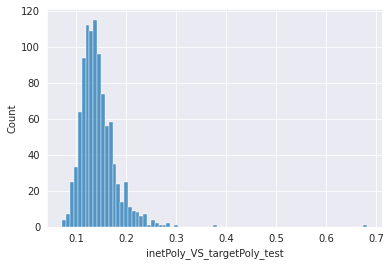

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

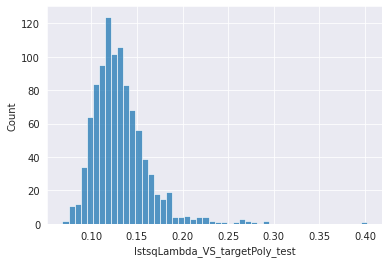

In [36]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

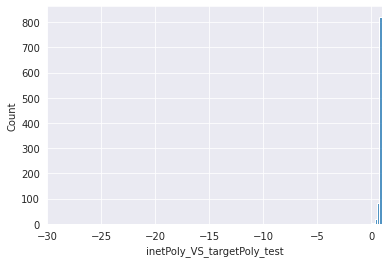

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

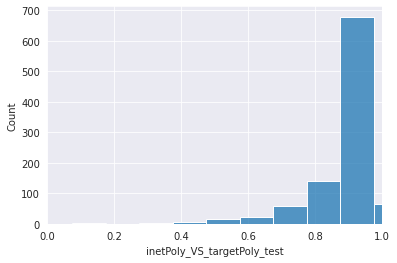

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

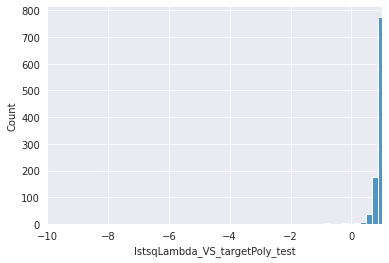

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

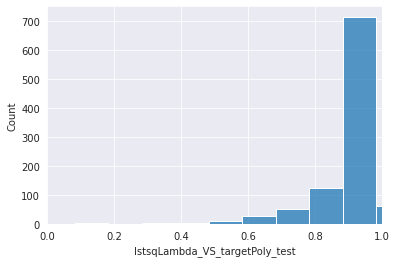

In [40]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [42]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [45]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [46]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


-0.2766*a**1.0*b**1.0*c**1.0 - 0.551*a**1.0*b**1.0*c**2.0 - 0.6562*a**1.0*b**1.0*c**3.0 + 0.2147*a**1.0*b**1.0 - 0.4148*a**1.0*b**2.0*c**1.0 + 0.0775*a**1.0*b**2.0*c**2.0 - 0.3452*a**1.0*b**2.0 + 0.7482*a**1.0*b**3.0*c**1.0 + 0.0031*a**1.0*b**3.0 - 0.2946*a**1.0*b**4.0 + 0.02*a**1.0*c**1.0 - 0.1999*a**1.0*c**2.0 + 0.6372*a**1.0*c**3.0 + 0.651*a**1.0*c**4.0 - 0.7997*a**1.0 - 0.2891*a**2.0*b**1.0*c**1.0 - 0.0084*a**2.0*b**1.0*c**2.0 - 0.0879*a**2.0*b**1.0 - 0.0743*a**2.0*b**2.0*c**1.0 + 0.9381*a**2.0*b**2.0 - 0.1577*a**2.0*b**3.0 - 0.4365*a**2.0*c**1.0 + 0.2178*a**2.0*c**2.0 - 0.0067*a**2.0*c**3.0 - 0.7931*a**2.0 - 0.4225*a**3.0*b**1.0*c**1.0 + 0.0696*a**3.0*b**1.0 + 0.5774*a**3.0*b**2.0 + 0.2893*a**3.0*c**1.0 + 0.2689*a**3.0*c**2.0 + 0.6333*a**3.0 - 0.8599*a**4.0*b**1.0 - 0.0115*a**4.0*c**1.0 - 0.7781*a**4.0 - 0.5091*a**5.0 - 0.3278*b**1.0*c**1.0 - 0.8931*b**1.0*c**2.0 + 0.9612*b**1.0*c**3.0 + 0.5858*b**1.0*c**4.0 + 0.9776*b**1.0 - 0.2513*b**2.0*c**1.0 + 0.5147*b**2.0*c**2.0 + 0.739*b**

LSTSQ Target Poly:


1.6336*a**1.0*b**1.0*c**1.0 + 6.1149*a**1.0*b**1.0*c**2.0 + 2.5442*a**1.0*b**1.0*c**3.0 - 1.8959*a**1.0*b**1.0 - 1.7373*a**1.0*b**2.0*c**1.0 - 5.385*a**1.0*b**2.0*c**2.0 - 2.5386*a**1.0*b**2.0 + 4.8842*a**1.0*b**3.0*c**1.0 + 4.3391*a**1.0*b**3.0 - 4.5326*a**1.0*b**4.0 + 1.3901*a**1.0*c**1.0 - 3.4004*a**1.0*c**2.0 - 0.1875*a**1.0*c**3.0 - 1.4511*a**1.0*c**4.0 + 0.439*a**1.0 - 16.8285*a**2.0*b**1.0*c**1.0 - 3.5046*a**2.0*b**1.0*c**2.0 + 1.1544*a**2.0*b**1.0 + 0.3135*a**2.0*b**2.0*c**1.0 + 4.8172*a**2.0*b**2.0 + 3.3796*a**2.0*b**3.0 + 2.2683*a**2.0*c**1.0 + 8.2873*a**2.0*c**2.0 + 1.6503*a**2.0*c**3.0 - 1.8023*a**2.0 + 12.3982*a**3.0*b**1.0*c**1.0 + 3.8592*a**3.0*b**1.0 - 6.4102*a**3.0*b**2.0 - 5.3675*a**3.0*c**1.0 - 5.5489*a**3.0*c**2.0 - 3.8185*a**3.0 - 2.8838*a**4.0*b**1.0 + 2.5161*a**4.0*c**1.0 + 3.2535*a**4.0 + 0.0078*a**5.0 + 1.9144*b**1.0*c**1.0 - 2.4627*b**1.0*c**2.0 - 1.2651*b**1.0*c**3.0 + 0.741*b**1.0*c**4.0 + 0.7175*b**1.0 + 1.2471*b**2.0*c**1.0 + 3.0649*b**2.0*c**2.0 - 1.8104*

LSTSQ Lambda Poly:


1.6336*a**1.0*b**1.0*c**1.0 + 6.1149*a**1.0*b**1.0*c**2.0 + 2.5442*a**1.0*b**1.0*c**3.0 - 1.8959*a**1.0*b**1.0 - 1.7373*a**1.0*b**2.0*c**1.0 - 5.385*a**1.0*b**2.0*c**2.0 - 2.5386*a**1.0*b**2.0 + 4.8842*a**1.0*b**3.0*c**1.0 + 4.3391*a**1.0*b**3.0 - 4.5326*a**1.0*b**4.0 + 1.3901*a**1.0*c**1.0 - 3.4004*a**1.0*c**2.0 - 0.1875*a**1.0*c**3.0 - 1.4511*a**1.0*c**4.0 + 0.439*a**1.0 - 16.8285*a**2.0*b**1.0*c**1.0 - 3.5046*a**2.0*b**1.0*c**2.0 + 1.1544*a**2.0*b**1.0 + 0.3135*a**2.0*b**2.0*c**1.0 + 4.8172*a**2.0*b**2.0 + 3.3796*a**2.0*b**3.0 + 2.2683*a**2.0*c**1.0 + 8.2873*a**2.0*c**2.0 + 1.6503*a**2.0*c**3.0 - 1.8023*a**2.0 + 12.3982*a**3.0*b**1.0*c**1.0 + 3.8592*a**3.0*b**1.0 - 6.4102*a**3.0*b**2.0 - 5.3675*a**3.0*c**1.0 - 5.5489*a**3.0*c**2.0 - 3.8185*a**3.0 - 2.8838*a**4.0*b**1.0 + 2.5161*a**4.0*c**1.0 + 3.2535*a**4.0 + 0.0078*a**5.0 + 1.9144*b**1.0*c**1.0 - 2.4627*b**1.0*c**2.0 - 1.2651*b**1.0*c**3.0 + 0.741*b**1.0*c**4.0 + 0.7175*b**1.0 + 1.2471*b**2.0*c**1.0 + 3.0649*b**2.0*c**2.0 - 1.8104*

I-Net Poly:


-0.0019000000320375*a**1.0*b**1.0*c**1.0 - 0.0750999972224236*a**1.0*b**1.0*c**2.0 + 0.156299993395805*a**1.0*b**1.0*c**3.0 - 0.167300000786781*a**1.0*b**1.0 + 0.108999997377396*a**1.0*b**2.0*c**1.0 + 0.0198999997228384*a**1.0*b**2.0*c**2.0 - 0.10809999704361*a**1.0*b**2.0 + 0.189300000667572*a**1.0*b**3.0*c**1.0 - 0.0337999984622002*a**1.0*b**3.0 + 0.109700001776218*a**1.0*b**4.0 - 0.18189999461174*a**1.0*c**1.0 + 0.0659999996423721*a**1.0*c**2.0 + 0.0807000026106834*a**1.0*c**3.0 + 0.0456000007688999*a**1.0*c**4.0 - 0.0740000009536743*a**1.0 - 0.308200001716614*a**2.0*b**1.0*c**1.0 - 0.049100000411272*a**2.0*b**1.0*c**2.0 - 0.467400014400482*a**2.0*b**1.0 - 0.0297999996691942*a**2.0*b**2.0*c**1.0 - 0.0838000029325485*a**2.0*b**2.0 + 0.284900009632111*a**2.0*b**3.0 - 0.144899994134903*a**2.0*c**1.0 - 0.0208999998867512*a**2.0*c**2.0 + 0.190500006079674*a**2.0*c**3.0 - 0.689899981021881*a**2.0 - 0.187999993562698*a**3.0*b**1.0*c**1.0 - 0.165500000119209*a**3.0*b**1.0 + 0.02889999933540

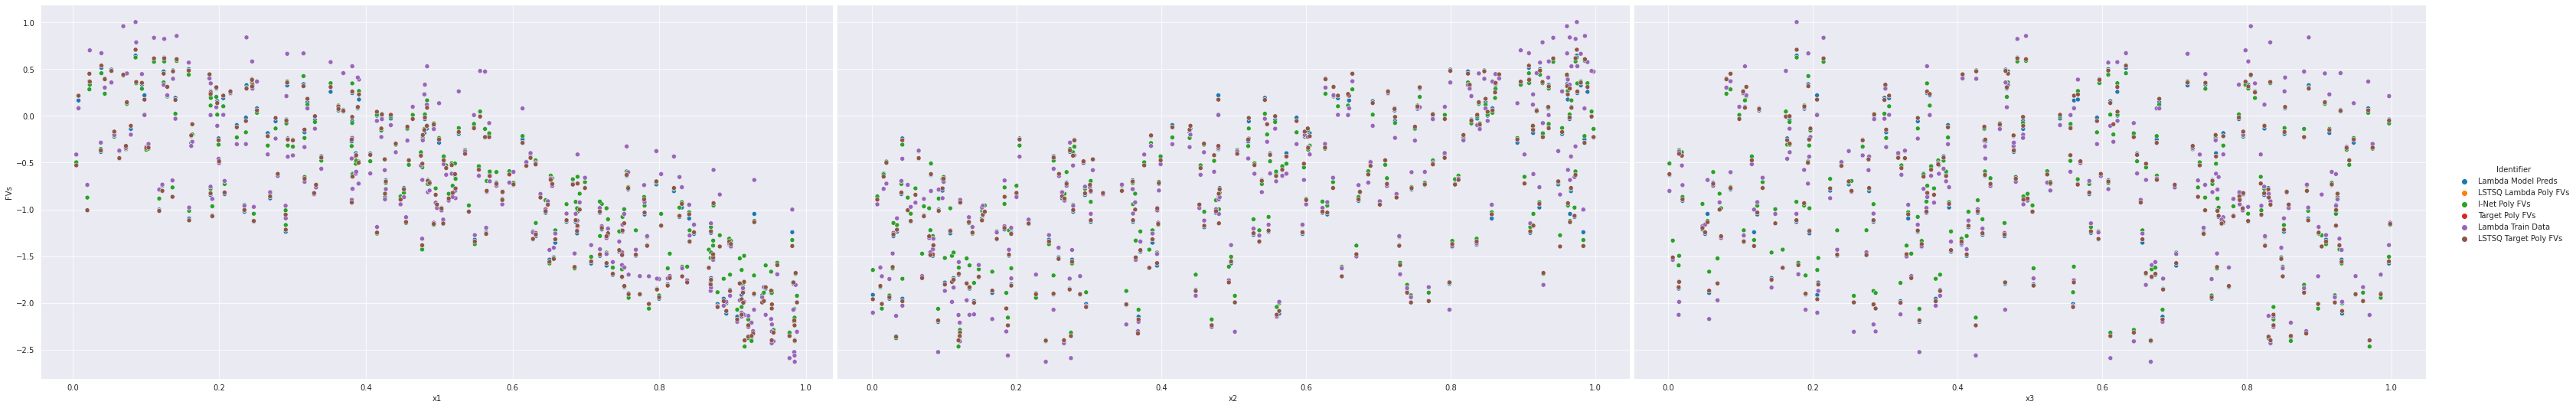

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.016969162049408612 | 0.9991719127770129 |   -    |           1.6336*a**1.0*b**1.0*c**1.0 +            |
|            vs.            |                      |                    |        |           6.1149*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 2.5442*a**1.0*b**1.0*c**3.0 - 1.8959*a**1.0*b**1.0 |
|                           |                      |                    |        |          - 1.7373*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

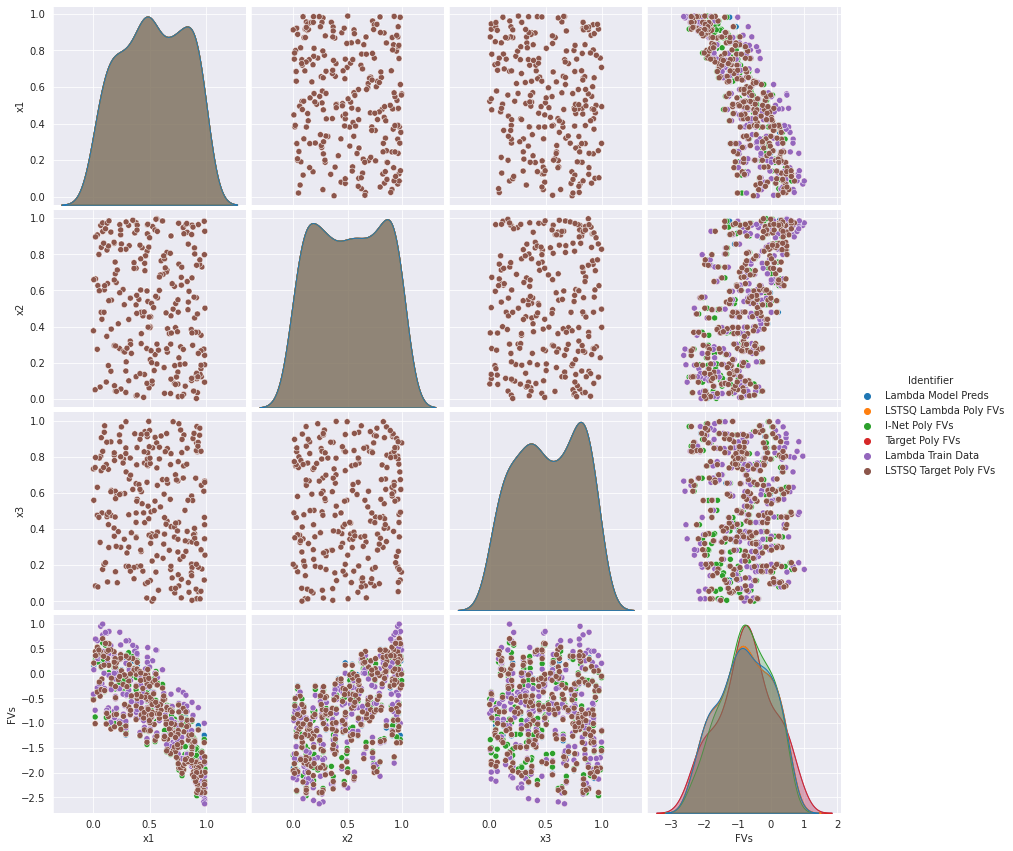

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.016969162049408612 | 0.9991719127770129 |   -    |           1.6336*a**1.0*b**1.0*c**1.0 +            |
|            vs.            |                      |                    |        |           6.1149*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 2.5442*a**1.0*b**1.0*c**3.0 - 1.8959*a**1.0*b**1.0 |
|                           |                      |                    |        |          - 1.7373*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

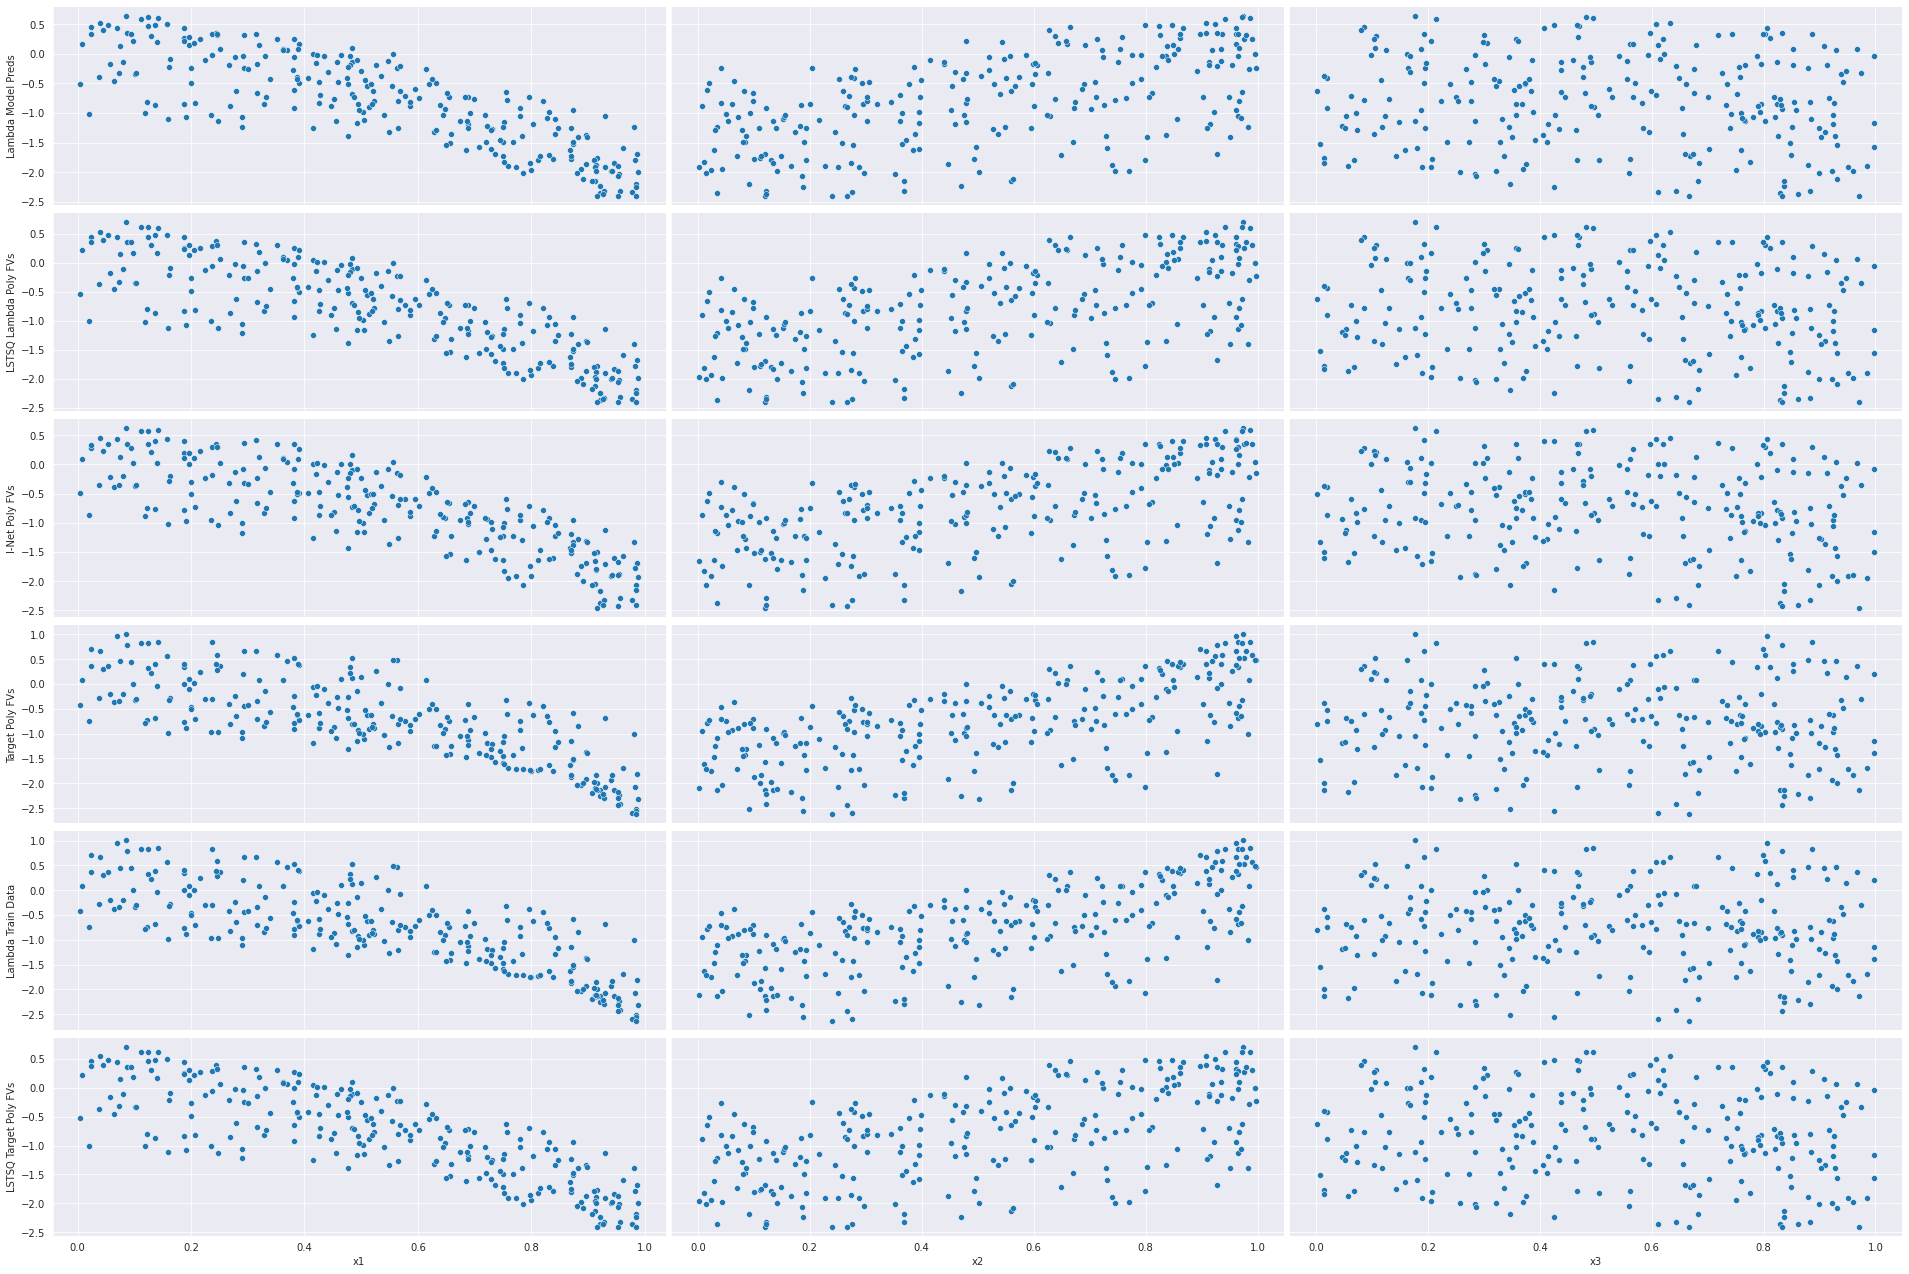

+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE          |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+----------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.016969162049408612 | 0.9991719127770129 |   -    |           1.6336*a**1.0*b**1.0*c**1.0 +            |
|            vs.            |                      |                    |        |           6.1149*a**1.0*b**1.0*c**2.0 +            |
|  LSTSQ Lambda Preds Poly  |                      |                    |        | 2.5442*a**1.0*b**1.0*c**3.0 - 1.8959*a**1.0*b**1.0 |
|                           |                      |                    |        |          - 1.7373*a**1.0*b**2.0*c**1.0 -           |
|                           |                   

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [50]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [51]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

In [52]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0086


In [53]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 9.9791


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [54]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [55]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 1.0035


In [56]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [57]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()